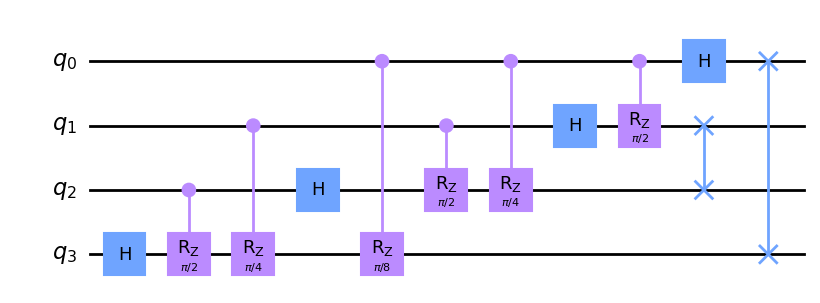

In [98]:
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from math import pi

def qft(n):
    # qft on n qubits
    q = QuantumRegister(n, 'q')
    qc = QuantumCircuit(q, name='qft')
    for j in range(n-1, -1, -1):
        qc.h(q[j])
        for k in range(j-1, -1, -1):
            qc.crz(pi/float(2**(j-k)), q[k], q[j])
    for j in range(n//2):
        qc.swap(q[j], q[n-j-1])
    return qc

qft(4).draw(output='mpl')
    

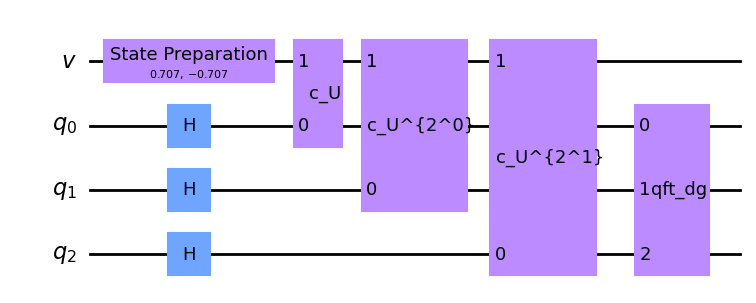

In [99]:
from math import log2

def phase_estimation(n, gate: QuantumCircuit, v: Statevector):
    m = gate.num_qubits
    assert m == log2(v.dim), 'gate and statevector must have same dimension'
    q_v = QuantumRegister(m, 'v')
    q = QuantumRegister(n, 'q')
    qc = QuantumCircuit(q_v, q, name='phase_est')
    qc.prepare_state(v, q_v)
    for j in range(n):
        qc.h(q[j])
    for j in range(n):
        qc.append(gate.control(), [q[j]] + q_v[:])
        new_gate = gate.copy()
        new_gate.name = 'U^{2^%d}' % j
        new_gate.append(gate.to_gate(), [i for i in range(m)])
        gate = new_gate
    qc.append(qft(n).inverse(), q)
    return qc

U = QuantumCircuit(1, name='U')
U.x(0)
qc = phase_estimation(3, U, Statevector.from_label('-'))
# qc.measure_all()
qc.draw(output='mpl')

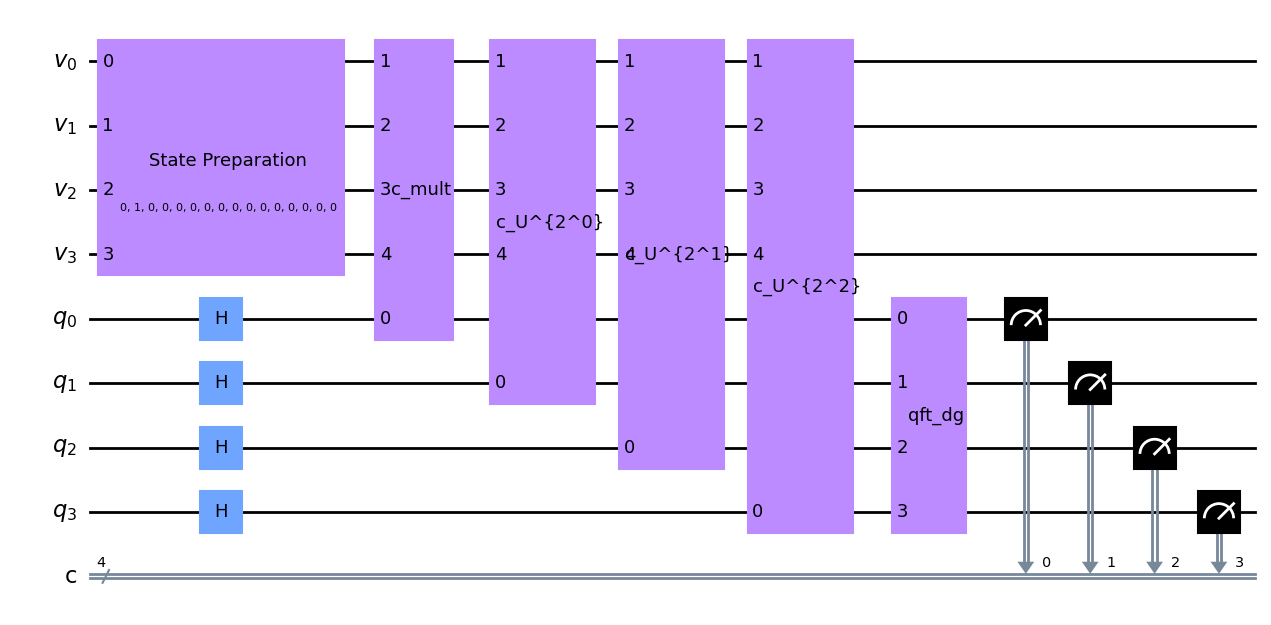

In [100]:
# mult: * 7 mod 15
mult = QuantumCircuit(4, name='mult')
for i in range(4): mult.x(i)
mult.swap(1, 2)
mult.swap(2, 3)
mult.swap(0, 3)
order_finding = phase_estimation(4, mult, Statevector.from_int(1, 16))
order_finding.draw(output='mpl')
# order_finding.save_statevector()
qc = order_finding
qc.add_register(ClassicalRegister(4, 'c'))
qc.measure([4,5,6,7], [0,1,2,3])
qc.draw("mpl")

# number of counts is the order of 7 mod 15

In [101]:
simulator = AerSimulator()
compiled_circuit = transpile(qc, simulator)

job = simulator.run(compiled_circuit, shots=1000)

result = job.result()
counts = result.get_counts(compiled_circuit)
print("\nCounts:", counts)


Counts: {'0000': 260, '1000': 227, '0100': 253, '1100': 260}


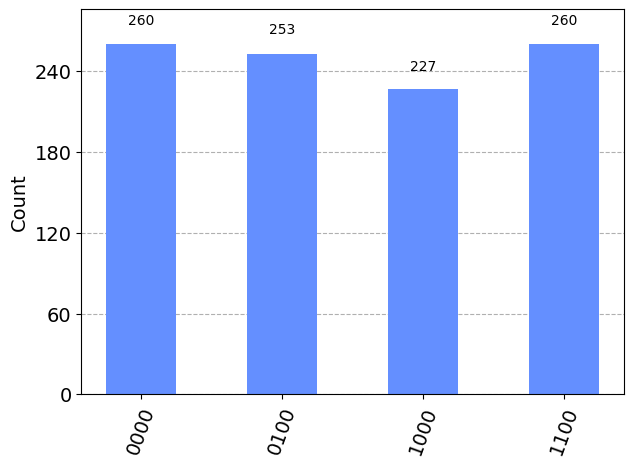

In [102]:
plot_histogram(counts)

There are four possible counts. This suggests the order of 7 mod 15 is 4. Checking, 7^4 = 49^2 = 4^2 = 16 = 1 (mod 15) indeed.